In [145]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score


In [115]:
df = pd.read_csv("New Final Candidates Cleaned.csv")

In [117]:
df.columns

Index(['Unnamed: 0', 'geo_name', 'year', 'votes', 'vote_share', 'incumbent',
       'winner', 'prob_democrat', 'prob_republican', 'pid_est', 'prob_male',
       'prob_female', 'gender_est', 'prob_black', 'prob_white',
       'prob_hispanic', 'prob_asian', 'prob_other', 'race_est',
       'contributor.cfscore', 'percent_women', 'percent_white',
       'percent_black', 'percent_hispanic', 'percent_asian_american',
       'candidate_count', 'UE 12Mo Avg', 'UE 12Mo Max', 'UE 12Mo Min',
       'UE 3Mo Avg', 'UE 3Mo Max', 'UE 3Mo Min', 'CPI 12Mo Avg',
       'CPI 12Mo Max', 'CPI 12Mo Min', 'CPI 3Mo Avg', 'CPI 3Mo Max',
       'CPI 3Mo Min', 'pid_est_knn', 'gender_est_knn', 'race_est_knn'],
      dtype='object')

***Features engineering***

In [132]:
df['c_female'] = df['gender_est'].map(lambda val: 1 if val == 'F' else 0)
df['c_democrats'] = df['pid_est'].map(lambda val: 1 if val == 'D' else 0)
df['c_republicans'] = df['pid_est'].map(lambda val: 1 if val == 'R' else 0)
df['c_white'] = df['race_est'].map(lambda val: 1 if val == 'caucasian' else 0)
df['c_hispanic'] = df['race_est'].map(lambda val: 1 if val == 'hispanic' else 0)
df['c_black'] = df['race_est'].map(lambda val: 1 if val == 'black' else 0)
df['c_asian'] = df['race_est'].map(lambda val: 1 if val == 'asian' else 0)
df['c_other'] = df['race_est'].map(lambda val: 1 if val == 'other' else 0)

***Features matrix***

In [189]:
features_m1 = ['incumbent']

features_m2 = ['incumbent', 'candidate_count']

features_m3 = ['incumbent', 'candidate_count', 'c_female',
               'c_democrats', 'c_republicans', 'contributor.cfscore',
               'c_white', 'c_hispanic', 'c_black', 'c_asian', 'c_other']

features_m3 = ['incumbent', 'candidate_count', 'c_female',
               'c_democrats', 'c_republicans', 'contributor.cfscore',
               'c_white', 'c_hispanic', 'c_black', 'c_asian', 'c_other',
               'percent_women', 'percent_white'] # different column name

features_m4 = ['incumbent', 'candidate_count', 'c_female',
               'c_democrats', 'c_republicans', 'contributor.cfscore',
               'c_white', 'c_hispanic', 'c_black', 'c_asian', 'c_other',
               'percent_women', 'percent_white',
               'CPI 12Mo Avg', 'UE 12Mo Avg']

features_m5 = ['incumbent', 'candidate_count', 'c_female',
               'c_democrats', 'c_republicans', 'contributor.cfscore',
               'c_white', 'c_hispanic', 'c_black', 'c_asian', 'c_other',
               'percent_women', 'percent_white',
               'CPI 3Mo Avg', 'UE 3Mo Avg']

features_m6 = ['incumbent', 'candidate_count', 'pid_est_knn', 'gender_est_knn', 'race_est_knn',
               'percent_women', 'percent_white', 'contributor.cfscore',
               'CPI 12Mo Avg', 'UE 12Mo Avg']

features_m7 = ['incumbent', 'candidate_count', 'pid_est_knn', 'gender_est_knn', 'race_est_knn',
               'percent_women', 'percent_white', 'contributor.cfscore',
               'CPI 3Mo Avg', 'UE 3Mo Avg']



***Logistic regression and hyperparameter***

In [190]:
def confusionMatrix(y_test, y_prod):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_prod)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [199]:
def roc(y_test, y_prob):
    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [192]:
def logistic(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100], #inverse of the regularization strength, prevent overfitting
        'penalty': ['l1', 'l2'], #Lasso-like, Ridge-like
        'solver': ['liblinear', 'saga'] #solved optimization. Other: 'lbfgs', 'newton-cg', 'sag'
    }

    # GridSearchCV with cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV (
        estimator  = LogisticRegression(random_state=42),
        param_grid = param_grid,  # Use demo_param_grid for quicker execution
                cv = cv,
        #scoring='precision_recall_curve',
            refit = 'PR_AUC',  # Refit based on PR AUC
            n_jobs = -1,
        verbose = 2,
        return_train_score=True,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'PR_AUC': 'average_precision'
        }
    )
    grid_search.fit(X_train, y_train)
    print("\nBest parameters:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_pred))

    confusionMatrix(y_test, y_pred)
    roc(y_test, y_prob)
    

***Try different feature matirx***

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, sol

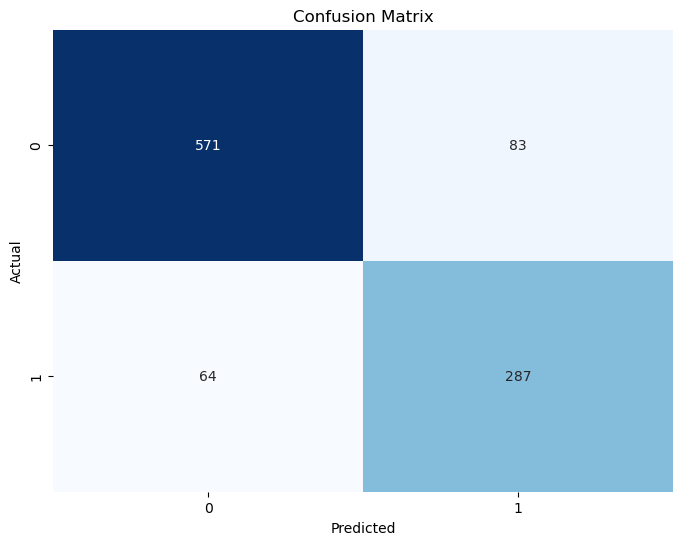

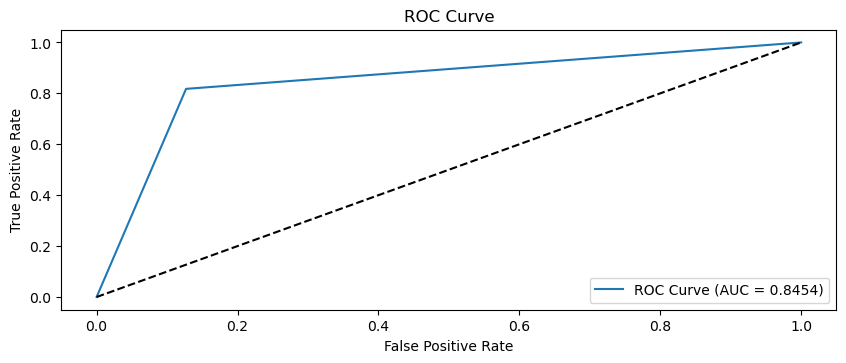

In [200]:
logistic(df[features_m1], df['winner'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, sol

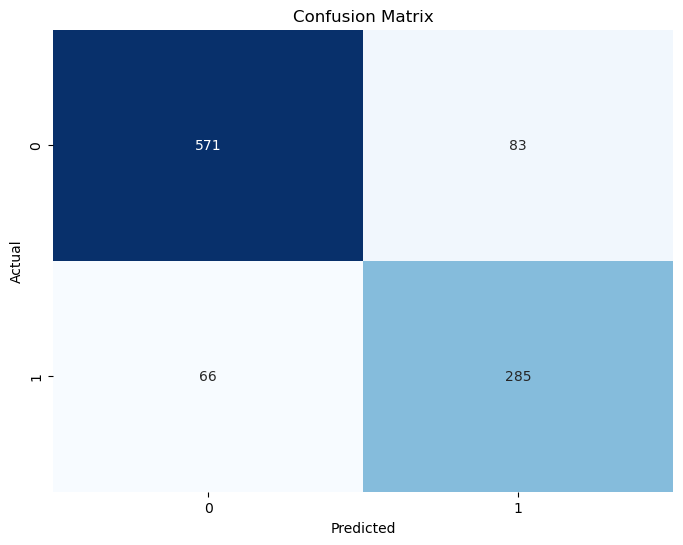

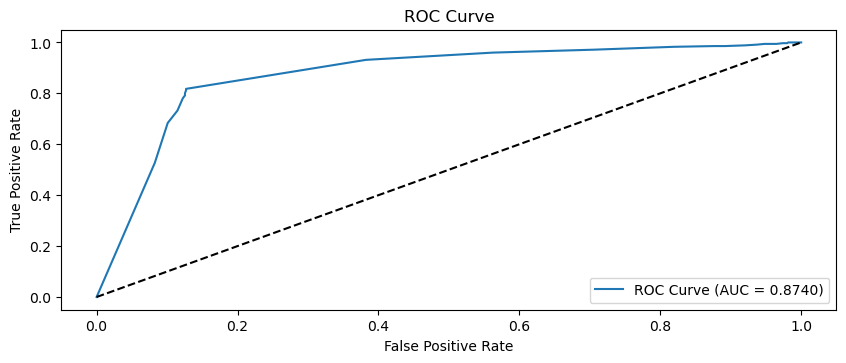

In [201]:
logistic(df[features_m2], df['winner'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, sol

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ...................

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s

Best parameters:
{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       654
           1       0.77      0.79      0.78       351

    accuracy                           0.85      1005
   macro avg       0.83      0.83      0.83      1005
weighted avg       0.85      0.85      0.85      1005



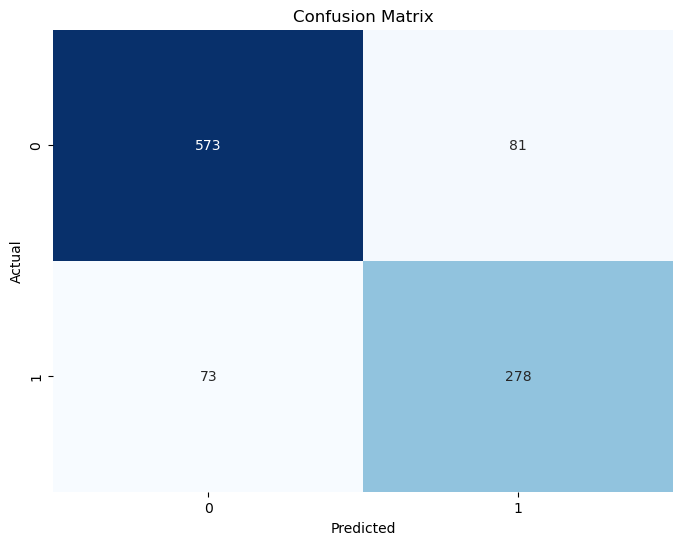

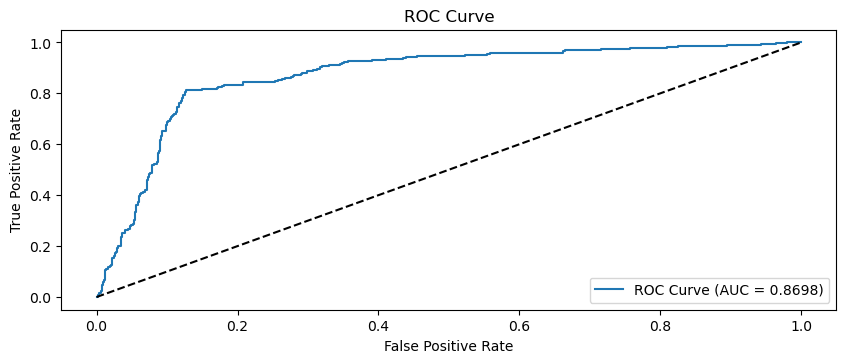

In [202]:
logistic(df[features_m3], df['winner'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.2s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.2s


/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.3s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s


/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=1

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.2s

Best parameters:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       654
           1       0.77      0.81      0.79       351

    accuracy                           0.85      1005
   macro avg       0.84      0.84      0.84      1005
weighted avg       0.85      0.85      0.85      1005



/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


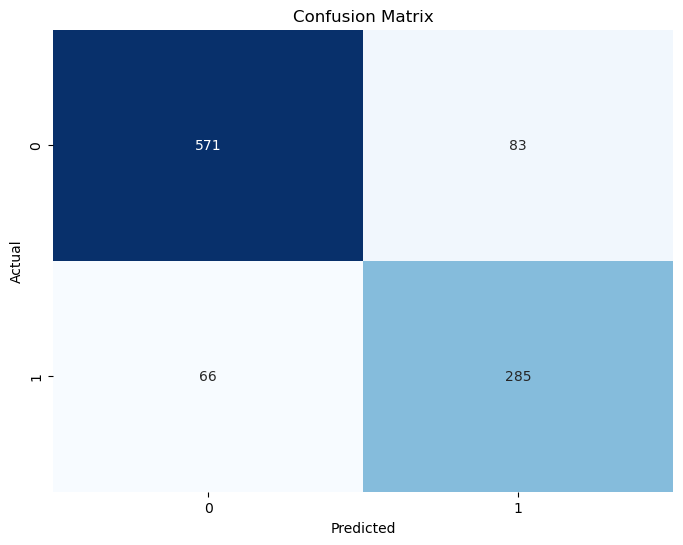

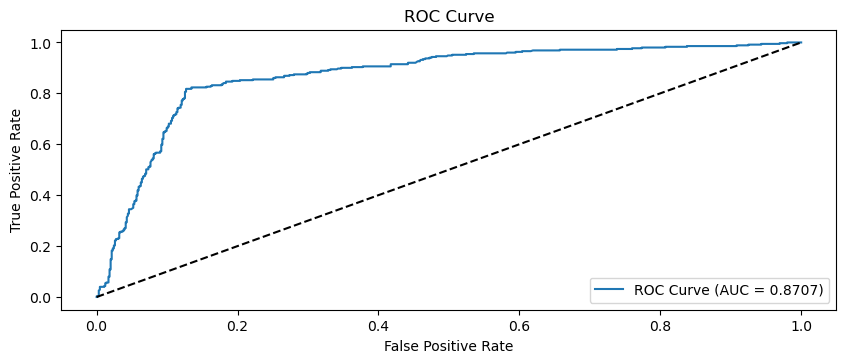

In [204]:
logistic(df[features_m4], df['winner'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l1

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s


/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.3s


/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.3s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s
[CV] END ...................

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s

Best parameters:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       654
           1       0.77      0.81      0.79       351

    accuracy                           0.85      1005
   macro avg       0.83      0.84      0.84

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


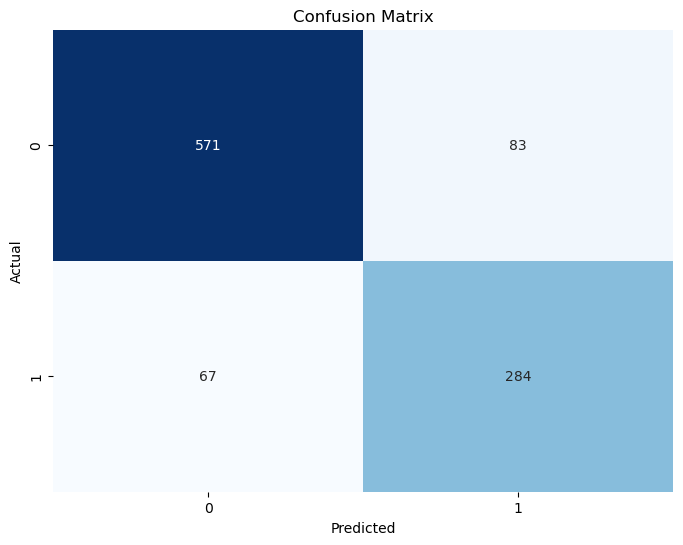

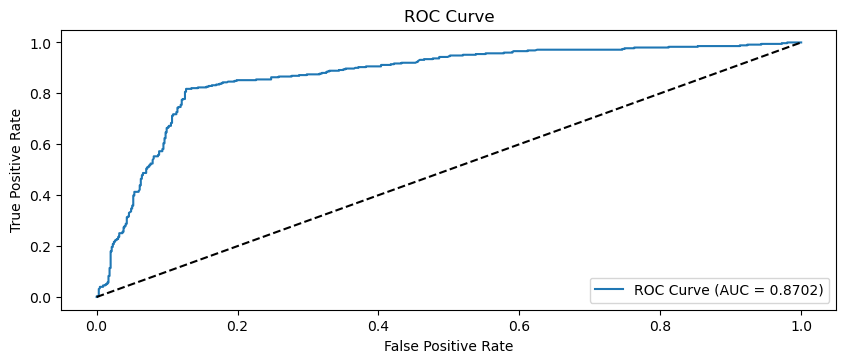

In [205]:
logistic(df[features_m5], df['winner'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l1

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s

[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................C=

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.2s


/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.3s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.3s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.3s

[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...................

/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.12/site-pack

[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END ...................

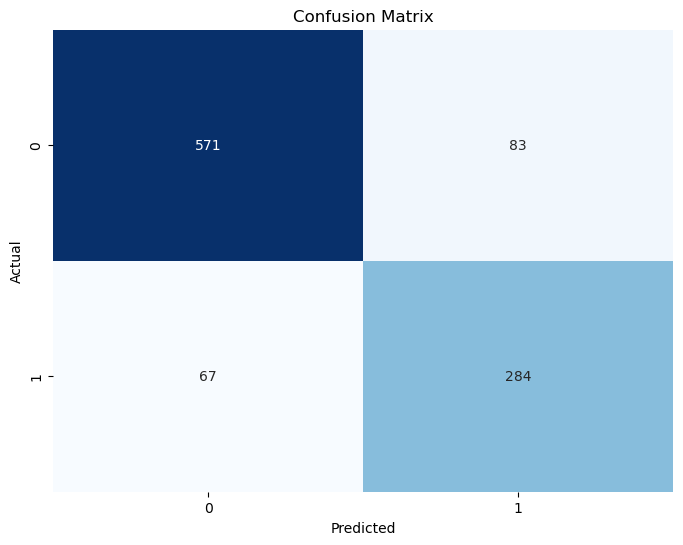

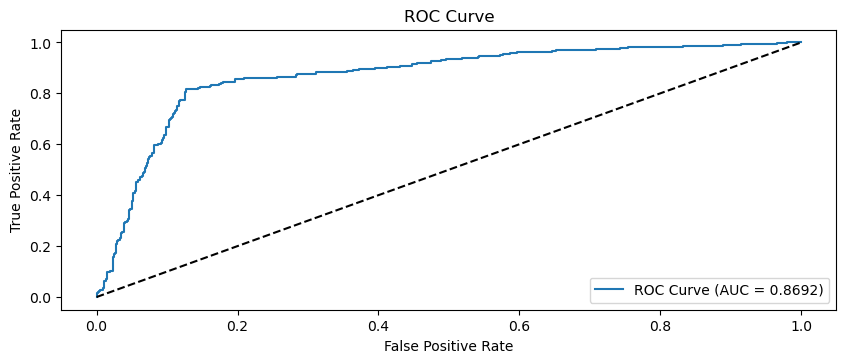

In [206]:
logistic(df[features_m6], df['winner'])